## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

In [3]:
from fastai.conv_learner import *
# PATH = Path("data/cifar10/")
PATH = "data/cifar10/"

In [4]:
bs=64
sz=32

In [5]:
tfms = tfms_from_model(resnet18, sz, aug_tfms=[RandomFlip()], pad=sz//8)
# data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train.csv', tfms=tfms, bs=bs)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [6]:
learn = ConvLearner.pretrained(resnet18, data)

In [7]:
lr=1e-2; wd=1e-5

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 650/782 [00:49<00:10, 13.11it/s, loss=6.38]

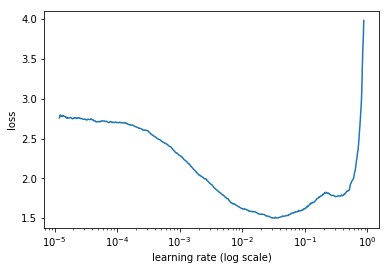

 83%|████████▎ | 650/782 [01:00<00:12, 10.82it/s, loss=6.38]

In [8]:
learn.lr_find()
learn.sched.plot()

In [9]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 13%|█▎        | 105/782 [00:04<00:29, 22.58it/s, loss=1.76]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.262726   1.075761   0.62908   



[1.0757606, 0.6290804140127388]

In [10]:
lrs = np.array([lr/9,lr/3,lr])

In [11]:
learn.unfreeze()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████  | 633/782 [00:45<00:10, 13.91it/s, loss=5.6] 

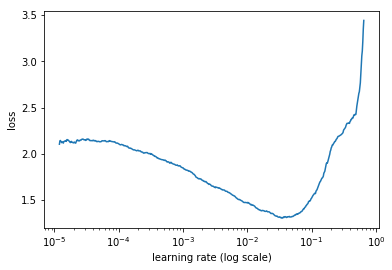

 81%|████████  | 633/782 [01:00<00:14, 10.54it/s, loss=5.6]

In [12]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [13]:
learn.fit(lrs, 1, cycle_len=1, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/782 [00:00<?, ?it/s]                    


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.876793   0.740113   0.743133  



[0.74011254, 0.7431329617834395]

## Simplenet

In [14]:
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159])) # mean, std

In [15]:
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
# data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train.csv', tfms=tfms, bs=bs)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [16]:
class SimpleConv(nn.Module):
    def __init__(self, ic, oc, ks=3, drop=0.2, bn=True):
        super().__init__()
        self.conv = nn.Conv2d(ic, oc, ks, padding=(ks-1)//2)
        self.bn = nn.BatchNorm2d(oc, momentum=0.05) if bn else None
        self.drop = nn.Dropout(drop, inplace=True)
        self.act = nn.ReLU(True)
        
    def forward(self, x):
        x = self.conv(x)
        if self.bn: x = self.bn(x)
        return self.drop(self.act(x))

In [17]:
net = nn.Sequential(
    SimpleConv(3, 64),
    SimpleConv(64, 128),
    SimpleConv(128, 128),
    SimpleConv(128, 128),
    nn.MaxPool2d(2),
    SimpleConv(128, 128),
    SimpleConv(128, 128),
    SimpleConv(128, 256),
    nn.MaxPool2d(2),
    SimpleConv(256, 256),
    SimpleConv(256, 256),
    nn.MaxPool2d(2),
    SimpleConv(256, 512),
    SimpleConv(512, 2048, ks=1, bn=False),
    SimpleConv(2048, 256, ks=1, bn=False),
    nn.MaxPool2d(2),
    SimpleConv(256, 256, bn=False, drop=0),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(256, 10)
)

In [18]:
bm = BasicModel(net.cuda(), name='simplenet')
learn = ConvLearner(data, bm)
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.unfreeze()
learn.metrics=[accuracy]
lr = 1e-3
wd = 5e-3 # weight decay

In [19]:
learn

Sequential(
  (0): SimpleConv(
    (conv): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True)
    (drop): Dropout(p=0.2, inplace)
    (act): ReLU(inplace)
  )
  (1): SimpleConv(
    (conv): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True)
    (drop): Dropout(p=0.2, inplace)
    (act): ReLU(inplace)
  )
  (2): SimpleConv(
    (conv): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True)
    (drop): Dropout(p=0.2, inplace)
    (act): ReLU(inplace)
  )
  (3): SimpleConv(
    (conv): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True)
    (drop): Dropout(p=0.2, inplace)
    (act): ReLU(inplace)
  )
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))


In [29]:
#sgd mom
learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 70%|██████▉   | 546/782 [02:39<01:09,  3.41it/s, loss=11.6]

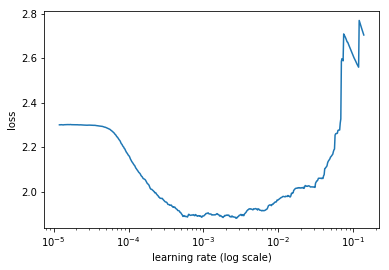

In [20]:
#adam
learn.lr_find()
learn.sched.plot()

In [21]:
learn.fit(lr, 1, wds=wd, cycle_len=20, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

  0%|          | 2/782 [00:00<05:33,  2.34it/s, loss=2.31]

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.396808   2.200464   0.221736  
    1      1.281023   1.721185   0.384156                   
    2      1.103166   1.289547   0.566083                   
    3      1.029159   1.188055   0.63127                    
    4      0.972705   1.201576   0.598229                    
    5      0.888741   1.00833    0.674662                    
    6      0.829941   1.040527   0.655155                    
    7      0.831834   1.090695   0.648288                    
    8      0.79633    1.056619   0.656748                    
    9      0.750656   0.827721   0.746616                    
    10     0.740221   0.847332   0.744825                    
    11     0.701216   0.79686    0.760251                    
    12     0.683933   0.783731   0.762042                    
    13     0.656835   0.722586   0.794686                    
    14     0.612873   0.686297   0.797273                    
    15     0.594434   0.66308 

[0.5311367, 0.8476313694267515]

In [22]:
learn.fit(lr, 1, wds=wd, cycle_len=5, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.758635   0.92774    0.717058  
    1      0.697191   0.863163   0.719049                    
    2      0.652325   0.782241   0.769904                    
    3      0.582722   0.617562   0.822651                    
    4      0.482959   0.562438   0.835191                    



[0.5624377, 0.8351910828025477]

In [23]:
learn.save('0')

In [24]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.536375   0.619387   0.825139  
    1      0.650775   0.747722   0.77289                     
    2      0.518328   0.585526   0.83758                     
    3      0.739827   0.990987   0.686704                    
    4      0.644217   0.843582   0.75199                     
    5      0.562827   0.604198   0.823248                    
    6      0.486811   0.549821   0.839072                    



[0.5498214, 0.8390724522292994]

In [25]:
learn.save('1')

In [26]:
learn.fit(lr, 1, wds=wd, cycle_len=10, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.76281    0.868122   0.730792  
    1      0.71548    0.917295   0.696955                    
    2      0.731272   0.814308   0.746119                    
    3      0.701616   0.895936   0.757564                    
    4      0.657036   0.795783   0.76453                     
    5      0.628775   0.692381   0.796875                    
    6      0.592506   0.700307   0.802249                    
    7      0.542455   0.614749   0.828523                    
    8      0.519356   0.584621   0.831708                    
    9      0.479849   0.52461    0.850717                    



[0.5246095, 0.8507165605095541]

In [27]:
learn.save('2')

## Fin